In [ ]:
import os
from pathlib import Path
import sys
sys.path.append(str(Path().resolve().parent))  # Add the project root to sys.path
import torch
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from utils.oct_dataset import OCTDataset
from utils.lossfunctions import DiceLoss
from utils.models import ResNetUNetWithAttention, MedSAM
from segment_anything import sam_model_registry
import torchmetrics

In [4]:
def save_image_with_prediction_and_mask(image, predicted, mask, image_id, save_dir, model_name):
    # Convert tensors to numpy arrays
    image_np = image.cpu().numpy().transpose(1, 2, 0)
    predicted_np = predicted.cpu().numpy().squeeze()
    mask_np = mask.cpu().numpy().squeeze()

    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the original image
    axes[0].imshow(image_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Plot the predicted mask
    axes[1].imshow(predicted_np, cmap="gray")
    axes[1].set_title("Predicted Mask")
    axes[1].axis("off")

    # Plot the ground truth mask
    axes[2].imshow(mask_np, cmap="gray")
    axes[2].set_title("Ground Truth Mask")
    axes[2].axis("off")

    # Save the figure
    save_path = os.path.join(save_dir, f"{image_id}_prediction_{model_name}.png")
    plt.savefig(save_path)
    plt.close(fig)


In [ ]:

def test_models(models_list, root_dir, save_dir):
    # Define device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Initialize lists to store results
    model_names = []
    dice_coeffs = []
    image_ids = []

    # Define dataset and transformations
    transform = transforms.Compose([
        transforms.Resize((1024, 1024), interpolation=Image.NEAREST),
        transforms.ToTensor(),
    ])

    test_dataset = OCTDataset(root_dir + "/data_gentuity",
        transform=transform,
        train=False,
        is_gentuity=True,
    )
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

    # Define loss function
    criterion = DiceLoss()

    # Loop through models and test each one
    for model_name, model_config in models_list:
        print(f"Testing model: {model_name}")

        # Initialize the model
        if model_config["model"] == "Unet":
            net = smp.Unet(
                encoder_name="resnet50",
                encoder_weights="imagenet",
                in_channels=3,
                classes=1,
            )
        elif model_config["model"] == "DeepLabV3+":
            net = smp.DeepLabV3Plus(
                encoder_name="resnet50",
                encoder_weights="imagenet",
                in_channels=3,
                classes=1,
            )
        elif model_config["model"] == "MedSam":
            sam_model = sam_model_registry['vit_b'](checkpoint=root_dir + "/medsam/medsam_vit_b.pth")
            net = MedSAM(
                image_encoder=sam_model.image_encoder,
                mask_decoder=sam_model.mask_decoder,
                prompt_encoder=sam_model.prompt_encoder,
            )
            checkpoint = torch.load(model_config["checkpoint_path"], weights_only=True)

            net.load_state_dict(checkpoint[0])


        elif model_config["model"] == "AttentionUnet":
            net = ResNetUNetWithAttention()

        # Load model checkpoint
        if(model_config["model"] != "MedSam"):
            checkpoint_path = model_config["checkpoint_path"]
            model_state, optimizer_state = torch.load(checkpoint_path, weights_only=True)
            net.load_state_dict(model_state)
        
        net.to(device)
        net.eval()

        # Test the model
        model_dice_scores = []
        total_loss = 0  # Accumulate loss for logging

        with torch.no_grad():  # Disable gradient calculation
            for image_id, data in enumerate(test_loader):
                if model_config["model"] == "MedSam":
                    # For MedSAM, process with bounding boxes
                    images, masks, _, _ = data
                    images, masks = images.to(device), masks.to(device)

                    # Get image dimensions
                    batch_size, _, height, width = images.size()

                    # Create bounding boxes covering the entire image
                    bboxes = torch.tensor([[0, 0, width, height]] * batch_size, dtype=torch.float32).unsqueeze(1).to(device)

                    # Predict outputs with bounding boxes
                    outputs = net(images, bboxes)
                    outputs = torch.sigmoid(outputs)
                    predicted = (outputs > 0.5).float()
                else:
                    # For other models
                    images, masks, _, _ = data
                    images, masks = images.to(device), masks.to(device)

                    outputs = net(images)
                    outputs = torch.sigmoid(outputs)
                    predicted = (outputs > 0.5).float()

                # Calculate loss dice score from torchmetrics
                dice_metric = torchmetrics.Dice().to(device)
                dice_score = dice_metric(predicted, masks.int())
                
                model_dice_scores.append(dice_score.item())
                print(f"Dice score: {dice_score.item():.4f}")

                # Save image with predictions and ground truth mask
                save_image_with_prediction_and_mask(images[0], predicted[0], masks[0], image_id, save_dir, model_name)

                # Store image ID for plotting later
                image_ids.append(image_id)

                print(f"Progress: {len(model_dice_scores)} / {len(test_loader)}", end="\r")

                # # if 10 images break
                # if len(model_dice_scores) == 5:
                #     break



        # Store results
        model_names.extend([model_name] * len(model_dice_scores))
        dice_coeffs.extend(model_dice_scores)

        print(f"{model_name} - Average Dice accuracy: {sum(model_dice_scores) / len(model_dice_scores):.4f}")
    
    return model_names, dice_coeffs


In [15]:
checkpoint = torch.load(root_dir+ "/checkpoints/medsam_frozen_bs=6_dicebce.pth", weights_only=True, map_location=torch.device('cpu'))

In [ ]:
# Run the function to get Dice scores and model names
root_dir = r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning"

models_list = [
    ("MedSAM Frozen", {"model": "MedSam", "checkpoint_path": root_dir+ "/checkpoints/medsam_frozen_bs=6_dicebce.pth"}),
    ("AttentionUnet Frozen", {"model": "AttentionUnet", "checkpoint_path": root_dir + "/checkpoints/attentionUnet_frozen_bs=6_dicebce.pt"}),
    ("U-Net Frozen", {"model": "Unet", "checkpoint_path": root_dir + "/checkpoints/unet_frozen_bs=6_dicebce.pt"}),
    ("DeepLabV3+ Frozen", {"model": "DeepLabV3+", "checkpoint_path": root_dir + "/checkpoints/deeplab_frozen_bs=6_dicebce.pt"}),
    ("MedSAM UnFrozen", {"model": "MedSam", "checkpoint_path": root_dir + "/checkpoints/medsam_unfrozen_bs=6_dicebce.pth"}),
    ("AttentionUnet UnFrozen", {"model": "AttentionUnet", "checkpoint_path": root_dir+ "/checkpoints/attentionUnet_unfrozen_bs=6_dicebce.pt"}),
    ("U-Net UnFrozen", {"model": "Unet", "checkpoint_path": root_dir + "/checkpoints/unet_unfrozen_bs=6_dicebce.pt"}),
    ("DeepLabV3+ UnFrozen", {"model": "DeepLabV3+", "checkpoint_path": root_dir + "/checkpoints/deeplab_unfrozen_bs=6_dicebce.pt"}),
]


save_dir = root_dir + "/output_images"  # Directory to save images with predictions
os.makedirs(save_dir, exist_ok=True)

model_names, dice_coeffs = test_models(models_list, root_dir, save_dir)

Testing model: MedSAM Frozen


c:\Users\johan\anaconda3\envs\dl\Lib\site-packages\segment_anything\build_sam.py:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location=t

Dice score: 0.9622
Dice score: 0.9609
Dice score: 0.9623
Dice score: 0.9654
Dice score: 0.9494
Dice score: 0.9422
Dice score: 0.9529
Dice score: 0.9355
Dice score: 0.9246
Dice score: 0.9476
Dice score: 0.9335
Dice score: 0.9302
Dice score: 0.9352
Dice score: 0.9482
Dice score: 0.9328
Dice score: 0.9387
Dice score: 0.9170
Dice score: 0.9260
Dice score: 0.8904
Dice score: 0.9060
Dice score: 0.9447
Dice score: 0.9296
Dice score: 0.9313
Dice score: 0.9548
Dice score: 0.9275
Dice score: 0.8860
Dice score: 0.8623
Dice score: 0.8530
Dice score: 0.8937
Dice score: 0.8620
Dice score: 0.8511
Dice score: 0.8562
Dice score: 0.8552
Dice score: 0.8040
Dice score: 0.8414
Dice score: 0.8356
Dice score: 0.8314
Dice score: 0.7898
Dice score: 0.7855
Dice score: 0.7925
Dice score: 0.7766
Dice score: 0.8192
Dice score: 0.7851
Dice score: 0.7802
Dice score: 0.7962
Dice score: 0.8138
Dice score: 0.8131
Dice score: 0.8260
Dice score: 0.7900
Dice score: 0.8096
Dice score: 0.6825
Dice score: 0.3767
Dice score: 

In [8]:
torch.cuda.empty_cache()

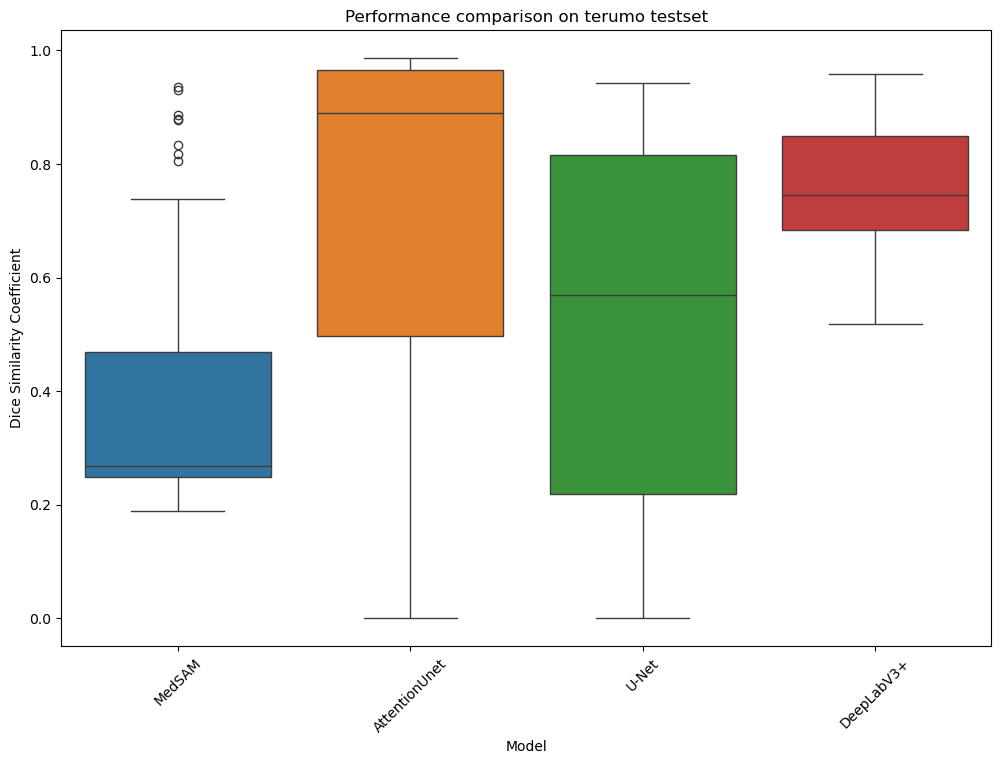

In [ ]:
# Create a DataFrame for visualization
results_df = pd.DataFrame({
    "Model": model_names,
    "Dice Score": dice_coeffs,
})

# Save the results to a csv file containing the model names and dice scores, and image_ids
results_df.to_csv("results_test_terumo.csv", index=False)


# Generate a boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x="Model", y="Dice Score", data=results_df, hue="Model", legend=False, showfliers=False)
plt.title("Performance comparison on terumo testset")
plt.ylabel("Dice Similarity Coefficient")
plt.xticks(rotation=45)
plt.show()

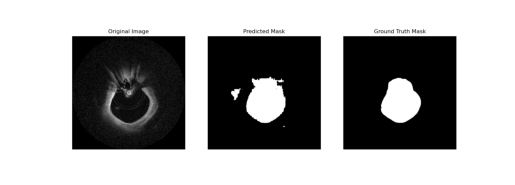

In [9]:
# Show saved image with predictions
# Open the image
image_path = "output_images/0_prediction_MedSAM.png"
image = Image.open(image_path)

# Display inline in the notebook
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()  # Display the image inline
